# 確率的ソロー・モデル

## 始める前に

次のセルの１行目以外をアンコメント（`# `を削除）しなさい。アンコメントするには次の手順に従う。
* Windowsの場合：１行目以外の全ての行を選択し，`Ctrl`を押したまま`/`を押す。
* Macの場合：１行目以外の全ての行を選択し，`command`を押したまま`/`を押す。

In [ ]:
# CELL PROVIDED
# import piplite
# await piplite.install(['py4macro','japanize-matplotlib-jlite'])
# %matplotlib inline
# import statsmodels
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (4, 3)

In [2]:
import japanize_matplotlib_jlite
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

np.set_printoptions(legacy='1.21')

## はじめに

この章の目的は２つある。
第一に，マクロ経済分析におけるランダム変数の役割と変数の持続性について考える。
第二に，景気循環を理解する上で全要素生産性の役割が強調される研究があるが，その導入として全要素生産性の特徴について検討する。

## 全要素生産性

### 説明

マクロ変数の特徴を捉えるにはホワイト・ノイズよりもAR(1)の方がより適しているということが分かった。では，どの様な形でAR(1)をマクロ・モデルに導入すれば良いのだろうか。現在盛んに行われている景気循環研究はDSGEモデル（**D**ynamic **S**tochastic **G**eneral **E**quilibrium Model）と呼ばれるモデルに基づいており、DSGEは名前が示すように次のような特徴がある。
* 時間軸に沿ってマクロ変数の変化を考察する動学的な特徴
* 確率的な要因の重要な役割
* 合理的期待に基づく将来を見据えた消費者と企業の最適行動
* 一般均衡のモデル

そして，DSGE研究の先駆けとなったモデルが実物的景気循環モデル（**R**eal **B**usiness **C**ycles Model; RBCモデル）と呼ばれる理論である。詳細については後の章に譲るが，基本的なアイデアは簡単で全要素生産性（TFP）がAR(1)に従って確率的に変動し，それが消費者と企業の経済行動に影響することにより景気循環が発生するという理論である。ここではデータを使い全要素生産性の性質を考察する。RBCモデルで需要な役割を果たす労働時間についてもデータを使い特徴を探ることにする。

### データ

次の生産関数を仮定する。

$$
Y_t=A_tK_t^aH_t^{1-a}
$$

* $Y_t$：GDP
* $K_t$：資本ストック
* $H_t$：総労働時間（労働者数$\times$労働者平均労働時間）
* $A_t$：TFP

TFPについて解くと次式を得る。

$$
A_t=\dfrac{Y_t}{K_t^aH_t^{1-a}}
$$

景気循環を考えているため、TFPを計算する際には次の点を考慮することが望ましい。
1. 年次データではなく四半期データを使う（年次データでは短期的な変動を捉えることができない）。
1. $H_t$は労働者数ではなく，総労働時間とする（短期的な労働供給の変化を捉えるため）。
1. $K_t$は資本ストックの稼働率を考慮したデータとする（短期的に実際に生産に使われた資本ストックの変化を捉えるため）。

ここでは１と２のみを考慮したデータを使いTFPの変動を考えることにする。これにより資本ストックの稼働率はTFPの一部となってしまうが，RBCモデルの基本的なアイデアは変わらない。

上で読み込んだデータ`df`には次の変数が含まれている（詳細は`GDP：水準・トレンド・変動`を参照）。
* 期間：1980年Q1〜2021年Q4
* `gdp`：国内総生産（支出側）
* `capital`：資本ストック
* `employed`：就業者
* `hours`：労働者1人あたり月平均就業時間（以下では「平均労働時間」と呼ぶ）
* `total_hours`：総労働時間（`hours`$\times$`employed`）

平均労働時間`hours`，就業者数`employed`，総労働時間`total_hours`の特徴を考えてみる。まずサイクルを計算し，それぞれの変数を図示しよう。（`employed`については対数化した就業者数のトレンドを計算しても良いが，結果は大きく変わらないため，ここでは対数を使わずに計算する。）

In [5]:
# CELL PROVIDED

# データの読み込み
df = py4macro.data('jpn-q')

# トレンドからの％乖離のデータの作成
df['gdp_cycle'] = 100 * (
    np.log( df['gdp'] ) - py4macro.trend( np.log(df['gdp']) )
)

# 平均労働時間
df['hours_trend'] = py4macro.trend( df['hours'] )
df['hours_cycle'] = 100 * np.log( df['hours'] / df['hours_trend'] )

# 就業者数
df['employed_log_trend'] = py4macro.trend( np.log(df['employed']) )
df['employed_cycle'] = 100 * ( np.log( df['employed'] ) - df['employed_log_trend'] )

# 総労働時間
df['total_hours_log_trend'] = py4macro.trend( np.log(df['total_hours']) )
df['total_hours_cycle'] = 100 * ( np.log( df['total_hours'] ) - df['total_hours_log_trend'] )

# 資本ストック
df['capital_log_trend'] = py4macro.trend( np.log(df['capital']) )
df['capital_cycle'] = 100 * ( 
    np.log( df['capital'] ) - df['capital_log_trend'] 
)

# cの値
c = 0.36

# 全要素生産性（対数）の計算
df['tfp_log'] = np.log( 
    df['gdp'] / ( df['capital']**c * df['total_hours']**(1-c) ) 
)

# 全要素生産性のトレンド（対数）の計算
df['tfp_log_trend'] = py4macro.trend( df['tfp_log'] )

# 全要素生産性のトレンドからの乖離率の計算
df['tfp_cycle'] = 100 * ( df['tfp_log'] - df['tfp_log_trend'] )

全要素生産性の変動をプロットしよう。

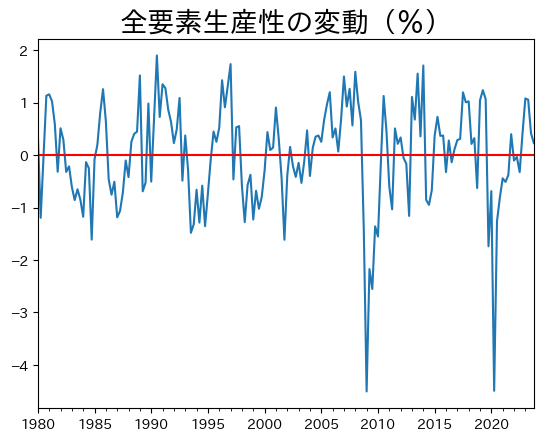

In [8]:
ax = df['tfp_cycle'].plot()
ax.axhline(0, c='red')
ax.set_title('全要素生産性の変動（％）', size=20)
pass

この図から全要素生産性の変動は大きいことが分かる。変動の最小値と最大値を確認してみよう。

In [9]:
df['tfp_cycle'].min(), df['tfp_cycle'].max()

(-4.507030513480492, 1.8997202364944288)

正の乖離は2％近くあり，負の乖離は4％以上となる。リーマンショック時を除くと正も負も絶対値で概ね2％以内に収まっている。

GDPと一緒にプロットしてみよう。

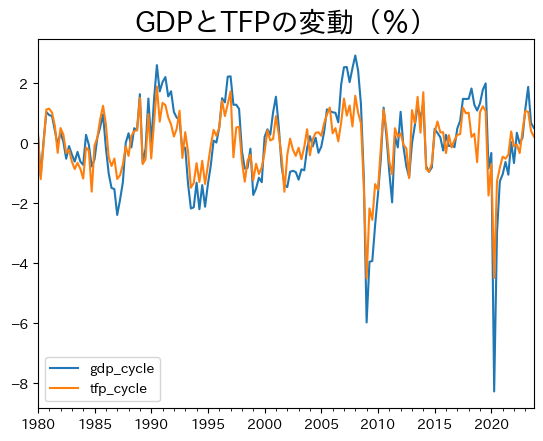

In [11]:
ax_ = df[['gdp_cycle','tfp_cycle']].plot()
ax_.set_title('GDPとTFPの変動（％）',size=20)
pass

同じ方向に動いているのが確認できる。GDPの変動との相関係数を計算してみると，非常に高いことがわかる。

In [12]:
df[['gdp_cycle','tfp_cycle']].corr().iloc[0,1]

0.9011737000769923

以前の計算結果を使うと，この数字はGDPのどの構成要素よりも高いことが確認できる。次に，自己相関係数を計算してみよう。

In [13]:
df['tfp_cycle'].autocorr()

0.5381766486069324

`gdp_cycle`程ではないが、強い持続性があることが確認できる。

In [14]:
df['gdp_cycle'].autocorr()

0.6974503788764269

＜これらの結果の含意＞

全要素生産性の変動は大きく持続性も高い。またGDPとの相関性も大きい。これらから全要素生産性が景気循環を引き起こす要因ではないかということが示唆される。全要素生産性は資本や労働時間で説明できないGDPの要素であり，そのような「その他」の部分に景気循環を引き起こすランダムな要素が隠されているかも知れない，という考え方である。

## 確率的ソロー・モデル

### AR(1)としてのTFP

全要素生産性を景気循環の要因として捉えるために，全要素生産性をAR(1)としてモデル化してみようというのがこの節の目的である。そのために`statsmodels`を使い回帰分析をしてみよう。まず１期ずらした変数を作成する。

In [16]:
df['tfp_cycle_lag'] = df['tfp_cycle'].shift()

In [17]:
# CELL PROVIDED

df[['tfp_cycle','tfp_cycle_lag']].head()

,tfp_cycle,tfp_cycle_lag
,,
1980-01-01,0.403866,NaN
1980-04-01,-1.195918,0.403866
1980-07-01,-0.010875,-1.195918
1980-10-01,1.132255,-0.010875
1981-01-01,1.159067,1.132255


列`tfp_cycle_lag`は列`tfp_cycle`を１期ずらしていることが確認できる。次に回帰分析をおこなう。

In [19]:
res_tfp = smf.ols('tfp_cycle ~ tfp_cycle_lag', data=df).fit()
rho = res_tfp.params['tfp_cycle_lag']
rho

0.5379980520919652

自己相関係数と殆ど変わらない値である。２つの変数の散布図を表示してみよう。

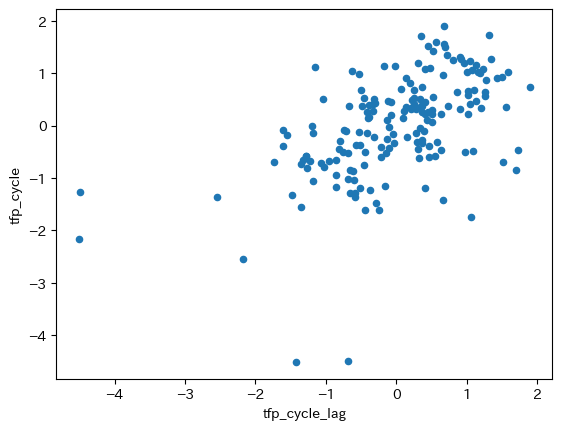

In [20]:
df.plot(x='tfp_cycle_lag', y='tfp_cycle', kind='scatter')
pass

正の相関が図でも確認できる。次に$\epsilon_t$について考える。この変数はホワイト・ノイズであり、TFPショックの「源泉」である。平均0の正規分布としてモデル化するが，上の回帰式の残差の標準偏差をTFPの標準偏差の推定値として考えよう。

In [21]:
sigma = res_tfp.resid.std()
sigma

0.8270723620184802

初期値は0として`rho`と`sigma`を使ってAR(1)の値を計算してプロットしてみよう。

自己相関係数：0.611


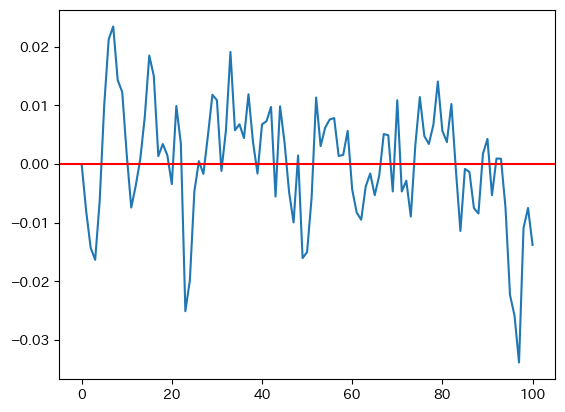

In [81]:
T = 100        # 標本の大きさ
A = 0          # 初期値
A_list = [A]   # 値を格納するリスト

for i in range(T):
    e = np.random.normal(loc=0,scale=sigma)
    A = rho*A+e
    A_list.append(A)

df_A = pd.Series(A_list)            # Seriesの作成
ax_ = df_A.plot()                   # 図示
ax_.axhline(0, c='red')             # 0の平行線

ac_tfp = df_A.autocorr()       # 自己相関係数の計算
print(f'自己相関係数：{ac_tfp:.3f}')

シミュレーションを行う度に図と自己相関係数は異なることになる。

### 説明

上で日本のデータを使い全要素生産性の`rho`と`sigma`を計算しシミュレーションを行なったが，そのような全要素生産性の変動が景気循環の主な要因と考えるのがRBCモデルと呼ばれるものである。RBCモデルの詳細については後の章で検討するが，ここではその導入としてソロー・モデルにAR(1)としてのTFPを組み込んでシミュレーションをおこない，計算結果をデータと比べてどの程度整合性があるかを検討する。

モデルの均衡式として以下を使う。
* 生産関数：$Y_t=A_tB_tK_t^aH^{1-a}$
    * $A_tB_t$が全要素生産性
    * $A_t$は変動を捉える項
    
        $$
        \begin{align*}
        \log(A_{t})&=\rho\log(A_{t-1})+\varepsilon_t \\
        \varepsilon_t&\sim \textit{WH}(0,\sigma^2)
        \end{align*}
        $$

    * $B_t$はトレンドを捉える項
    
        $$
        B_t=B_0(1+g)^t
        $$
    * $H$は一定と仮定する
    
* 資本の蓄積方程式：$K_{t+1}=sY_t+(1-d)K_t$
* 消費：$C_t=(1-s)Y_t$
* 投資（貯蓄）：$I_t=sY_t$

これらの式から次の2式で$K_t$と$A_t$の値が計算できる。

$$
\begin{align*}
K_{t+1}&=sA_tB_tK_t^aH^{1-a}+(1-d)K_t\\
\log(A_{t+1})&=\rho\log(A_{t})+\varepsilon_{t+1}
\end{align*}
$$

変数の初期値を次のように仮定する。
* $A_0=1$
* $K_0=$ 1980年の資本ストックの平均

$H$は次の値として一定とする。
* $H=$ 1980年の総労働時間の平均

パラメータの値を次を仮定する。
* $\rho$と$\sigma$は上で計算した`rho`と`sigma`の値
* $g=$ 1980年から最後の年までの平均四半期成長率
* $s=$ 1980年から最後の年までのGDPに占める投資の割合の平均
* $d=0.025$：年率約10％を想定
* $a=0.36$：資本の所得割合

シミュレーションの結果を次の変数を含む`DataFrame`にまとめる。
* $Y$，$C$，$I$，$K$，$A$の水準の系列
* $Y$，$C$，$I$，$K$，$A$のトレンドの系列
* $Y$，$C$，$I$，$K$，$A$の変動（サイクル）の系列

### 初期値の計算

まずGDP，資本，総労働時間の1980年と2019年の平均を計算する。

In [82]:
var_list = ['gdp','capital','total_hours']       #1
year_list = [df.index[0].year,df.index[-1].year] #2

gdp_dict = {}  #3
K_dict = {}    #4
H_dict = {}    #5

for yr in year_list:                     #6
    
    cond = ( df.index.year == yr)        #7
    mean = df.loc[cond, var_list].mean() #8
    gdp_dict[yr] = mean.iloc[0]  #9
    K_dict[yr] = mean.iloc[1]    #10
    H_dict[yr] = mean.iloc[2]    #11

```{admonition} コードの説明
:class: dropdown

* `#1`：３つの変数のリスト
* `#2`：平均を計算する年のリストであり，`df.index[0].year`と`df.index[-1].year`はインデックスから最初と最後の年を抽出する
* `#3`：それぞれの年のGDPの平均を格納する辞書
* `#4`：それぞれの年の資本ストックの平均を格納する辞書
* `#5`：それぞれの年の総労働時間の平均を格納する辞書
* `#6`：`year_list`に対しての`for`ループ
* `#7`：`df.index`の年が`yr`と同じ場合は`True`を返し，そうでない場合は`False`を返す`Series`を`cond`に割り当てる。
* `#8`：それぞれの年の行，`var_list`にある列を抽出し平均を計算する。
    * `.mean()`は列の平均を計算する。
    * 計算した平均は`Series`として返されるので，それを左辺にある変数`mean`に割り当てる。
* `#9`：`mean`の0番目の要素を`gdp_dict`のキー`yr`（年）に対応する値をして設定する。
* `#10`：`mean`の1番目の要素を`K_dict`のキー`yr`（年）に対応する値をして設定する。
* `#11`：`mean`の2番目の要素を`H_dict`のキー`yr`（年）に対応する値をして設定する。
```

このコードの結果を確認してみよう。例えば，

In [83]:
gdp_dict

{1980: 273013.55, 2023: 560278.625}

In [84]:
from myst_nb import glue
var_list = ['gdp','capital','total_hours']       #1
year_list = [df.index[0].year,df.index[-1].year] #2

gdp_dict = {}  #3
K_dict = {}    #4
H_dict = {}    #5

for yr in year_list:                     #6
    
    cond = ( df.index.year == yr)        #7
    mean = df.loc[cond, var_list].mean() #8
    gdp_dict[yr] = mean.iloc[0]  #9
    K_dict[yr] = mean.iloc[1]    #10
    H_dict[yr] = mean.iloc[2]    #11

start_ = list( gdp_dict.keys() )[0]
end_ = list( gdp_dict.keys() )[1]
glue("start_", start_, display=False)
glue("end_", end_, display=False)

ModuleNotFoundError: No module named 'myst_nb'

キー・値の２つのペアがある。キー{glue:}`start_`の値には{glue:}`start_`年のGDPの平均が設定されており，同様に，もう一つのキー{glue:}`end_`の値には{glue:}`end_`年のGDPの平均が設定されている。従って，次のコードで{glue:}`start_`年の値にアクセスできる。
```
gdp_dict[1980]
```
他の辞書も同様である。

````{admonition} なぜforループを使うのか。
:class: tip

上のコードで`for`ループを使っているが，もし使わなければ次のようなコードになる。
```
var_list = ['gdp','capital', 'total_hours']
mean1980 = df.loc['1980-01-01':'1980-10-01',var_list].mean()
mean2019 = df.loc['2019-01-01':'2019-10-01',var_list].mean()

gdp1980 = mean1980.iloc[0]
K1980 = mean1980.iloc[1]
H1980 = mean1980.iloc[2]

gdp2019 = mean2019.iloc[0]
K2019 = mean2019.iloc[1]
H2019 = mean2019.iloc[2]
```
同じようなコードが並んでいる。`py4macro`のデータがアップデートされて`2020`年までのデータが含まれることになったとしよう。`for`ループを使うコードであれば`2019`を`2020`に一ヵ所だけ変更すれば良い（変更する必要もないコードを書くことも可能）。`for`ループを使わないコードで何ヵ所修正する必要があるか数えてみよう。面倒と感じないだろうか。それに修正箇所が増えればbugが紛れ込む可能性が増えていく。
````

次に全要素生産性の平均四半期成長率を計算するために`df`の列名を確認しよう。

In [ ]:
df.columns

`gdp`は0番目，`capital`は6番目，`total_hours`は11番目の列にある。この情報をもとに次のように計算しよう。

In [ ]:
var_idx = [0,6,11]         # 1
df0 = df.iloc[0,var_idx]   # 2
df1 = df.iloc[-1,var_idx]  # 3

# 4
B0 = df0['gdp']/( df0['capital']**a * df0['total_hours']**(1-a))

# 5
B1 = df1['gdp']/( df1['capital']**a * df1['total_hours']**(1-a))

no_quarters = len(df)      # 6

g = (B1/B0)**(1/no_quarters)-1  # 7
g

```{admonition} コードの説明
:class: dropdown

1. 3つの変数の列インデックのリスト
2. 最初の行で3つの変数だけを抽出し`df0`に割り当てる。
3. 最後の行で3つの変数だけを抽出し`df1`に割り当てる。
4. 最初の四半期の全要素生産性の計算
5. 最後の四半期の全要素生産性の計算
6. 四半期の数
7. 平均四半期成長率の計算
```

次にGDPに対する投資の割合の平均を計算する。

In [ ]:
s = ( df['investment']/df['gdp'] ).mean()
s

約22％が投資に回されている。

### シミュレーション

#### 関数

シミュレーションのコードを関数としてまとめよう。

In [85]:
def stochastic_solow(T=160,  # 160=40*4 40年間の四半期の数
                     rho=rho,
                     sigma=sigma,
                     g=g,
                     s=s,
                     d=0.025,
                     a=a,
                     H=H_dict[1980],  # 1980年平均に固定
                     K0=K_dict[1980],
                     B0=B0):
    """引数：
            T:     シミュレーションの回数
            rho:   AR(1)のパラメータ
            sigma: ホワイト・ノイズ分散
            g:     TFPの平均四半期成長率
            s:     貯蓄率
            d:     資本減耗率
            a:     生産関数のパラメータ（資本の所得割合）
            H:     総労働時間
       返り値
            次の変数を含むDataFrame
            GDP，消費，投資，資本ストック，全要素生産性の水準，トレンド，変動"""
    
    # ========== A,B,Kの計算 ==========
    # 計算結果を格納するリスト
    A_list = [1]    # 1
    B_list = [B0]   # 2
    K_list = [K0]   # 3

    # 初期値でありアップデート用変数
    A = 1           # 4
    B = B0          # 5
    K = K0          # 6

    # A,B,Kの時系列の計算
    for t in range(1,T):
        K = s * A*B * K**a *H**(1-a) + (1-d)*K  # 7
        e = np.random.normal(0,scale=sigma)     # 8
        A = A**rho * np.exp(e)                  # 9
        B = B0*(1+g)**t                         # 10
        
        A_list.append(A)                        # 11
        B_list.append(B)
        K_list.append(K)
    
    # ========== DataFrameの作成 ==========
    df_sim = pd.DataFrame({'K':K_list,          # 12
                           'A':A_list,
                           'B':B_list})

    # ========== Y,C,Iの計算 ==========          # 13
    df_sim['Y'] = df_sim['A']*df_sim['B']*df_sim['K']**a * H**(1-a)
    df_sim['C'] = (1-s)*df_sim['Y']
    df_sim['I'] = s*df_sim['Y']
    
    # ========== トレンドとサイクルの計算 ==========
    for v in ['K','A','Y','C','I']:
        # ---------- レンドの計算 ----------      # 14
        df_sim[f'{v}_log_trend'] = py4macro.trend( np.log(df_sim[v]) )
        # ---------- サイクルの計算 ----------    # 15
        df_sim[f'{v}の変動'] = np.log( df_sim[v] ) - df_sim[f'{v}_log_trend']
    
    return df_sim

```{admonition} コードの説明
:class: dropdown

1. `A`の値を格納する空のリスト。初期値が入っている。
2. `B`の値を格納する空のリスト。初期値が入っている。
3. `K`の値を格納する空のリスト。初期値が入っている。
4. `for`ループでアップデートされる`A`の値を一次的に格納する。最初は初期値が入っている。
5. `for`ループでアップデートされる`B`の値を一次的に格納する。最初は初期値が入っている。
6. `for`ループでアップデートされる`K`の値を一次的に格納する。最初は初期値が入っている。
7. 右辺では(4)~(6)の値（`A`，`B`，`K`）を使い来期の`K`を計算し，その値を左辺の`K`に割り当てる。この瞬間に(6)の`K`がアップデートされる。
8. 来期のホワイト・ノイズの値を生成し`e`に割り当てる。
9. 右辺では(4)の値（`A`）を使い来期の`A`の値を計算し，その値を左辺の`A`に割り当てる。この瞬間に(4)の`A`がアップデートされる。
10. 右辺では来期の`B`の値を計算し，その値を左辺の`B`に割り当てる。この瞬間に(5)の`B`がアップデートされる。
11. リスト(1)~(3)に来期値を追加する。
12. リスト(1)~(3)を使いDataFrameの作成
13. `Y`，`C`，`I`を計算し新たな列としてDataFrameに追加
14. トレンドを計算し新たな列としてDataFrameに追加
    * `f-string`を使って新しく作る列名を`K_trend`のように`_trend`を追加する。
15. トレンドからの乖離を計算し新たな列としてDataFrameに追加
    * `f-string`を使って新しく作る列名を`K_cycle`のように`_cycle`を追加する。
```

#### 実行

デフォルトの値でシミュレーションを行い、最初の5行を表示する。

In [86]:
df_sim = stochastic_solow()
df_sim.head()

,K,A,B,Y,C,I,K_log_trend,Kの変動,A_log_trend,Aの変動,Y_log_trend,Yの変動,C_log_trend,Cの変動,I_log_trend,Iの変動
0,8.500536e+05,1.000000,0.366275,272071.676745,212986.674833,59085.001912,13.690684,-0.037629,-0.004145,0.004145,12.523222,-0.009401,12.278386,-0.009401,10.996134,-0.009401
1,8.878873e+05,0.987722,0.367161,273638.075072,214212.903065,59425.172007,13.723555,-0.026955,-0.004103,-0.008251,12.537517,-0.017955,12.292681,-0.017955,11.010428,-0.017955
2,9.251153e+05,1.002963,0.368050,282682.368414,221293.073953,61389.294461,13.756403,-0.018729,-0.004058,0.007016,12.551805,0.000274,12.306969,0.000274,11.024717,0.000274
3,9.633767e+05,0.992911,0.368942,284649.607071,222833.093205,61816.513866,13.789187,-0.010987,-0.004012,-0.003102,12.566071,-0.007057,12.321235,-0.007057,11.038983,-0.007057
4,1.001109e+06,0.995898,0.369835,290182.844637,227164.693922,63018.150715,13.821855,-0.005236,-0.003965,-0.000146,12.580297,-0.002031,12.335461,-0.002031,11.053209,-0.002031


$Y$の水準とトレンドの図示（対数）。

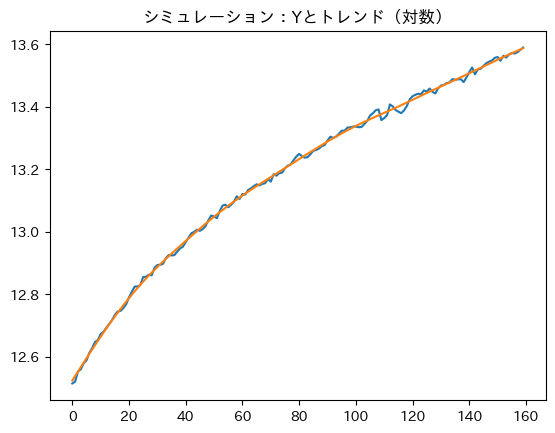

In [87]:
np.log( df_sim['Y'] ).plot(title='シミュレーション：Yとトレンド（対数）')
df_sim['Y_log_trend'].plot()
pass

トレンドの傾きは成長率を表しているが，徐々に減少していることが分かる。最初は成長率に対する資本蓄積の効果が大きいが，定常状態に近づくにつれて資本蓄積の効果が減少しているためである。

$Y$の変動（サイクル）の図示。

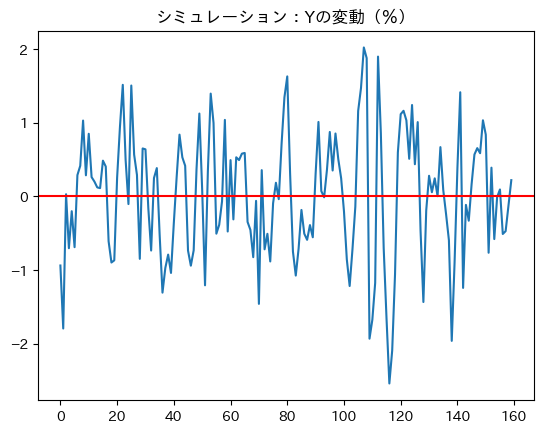

In [88]:
ax_ = ( 100 * df_sim['Yの変動'] ).plot(title='シミュレーション：Yの変動（％）')
ax_.axhline(0, c='red')
pass

絶対値で約2％内に収まった変動となっている。データでは，リーマンショック時はマイナス約4％程乖離したが，それ以外は絶対値で2％以内に収まっており，シミュレーションは概ねデータと同じような特徴を持っていると言える。

#### 結果

それぞれの変数の自己相関係数を計算してみる。

In [90]:
var_list = ['Y','C','I','K','A']

print('\n--- シミュレーション：変動の自己相関係数 ---\n')

for v in var_list:
    
    ac = df_sim[f'{v}の変動'].autocorr()
    print(f'{v}の変動： {ac:.3f}')


--- シミュレーション：変動の自己相関係数 ---

Yの変動： 0.463
Cの変動： 0.463
Iの変動： 0.463
Kの変動： 0.971
Aの変動： 0.441


まずシミュレーションを行う度にこれらの値は変化することに留意し結果を考えよう。ある程度の自己相関が発生しており，$A$の影響が反映されている。$Y$，$C$，$I$の値は同じなのは，$C$，$I$は$Y$の線形関数であるためであり，これらの３つの変数は$A$の変動と似た動きになっている。また$K$の値が大きいのは、ストック変数であるため変化に時間が掛かるためある。データ`df`に含まれる変数の自己相関係数と比べるために，まず消費，投資，資本の変動を計算する。

In [91]:
df.columns

Index(['gdp', 'consumption', 'investment', 'government', 'exports', 'imports',
       'capital', 'employed', 'unemployed', 'unemployment_rate', 'hours',
       'total_hours', 'inflation', 'price', 'deflator', 'gdp_cycle',
       'hours_trend', 'hours_cycle', 'employed_trend', 'employed_cycle',
       'total_hours_trend', 'total_hours_cycle', 'tfp_log', 'tfp_log_trend',
       'tfp_cycle', 'tfp_cycle_lag'],
      dtype='object')

In [92]:
data_var_list = ['consumption','investment','capital']

for v in data_var_list:
    
    df[f'{v}_cycle'] = np.log( df[v]/py4macro.trend(df[v]) )

結果を示すために，`data_var_list`の最初と最後に`gdp`と`tfp`を追加する。

In [88]:
data_var_list = ['gdp']+data_var_list+['tfp']

In [93]:
print('\n--- データ：変動の自己相関係数 ---\n')

for v in data_var_list:
    
    ac = df[f'{v}_cycle'].autocorr()
    print(f'{v:>11}の変動： {ac:>5.3f}')      # 1


--- データ：変動の自己相関係数 ---

consumptionの変動： 0.493
 investmentの変動： 0.838
    capitalの変動： 0.882


```{admonition} コードの説明
:class: dropdown

1. `f-string`を使って変数`v`と`ac`を代入している。
    * `:>11`は`v`を表示する幅を`11`に設定し右寄せ（`>`）にしている。
    * `:>5`は`ac`を表示する幅を`5`に設定して右寄せ（`>`）にしている。
    * `.3f`は`ac`を小数点第三位までを表示するように指定している。
```

実際の資本ストックは非常に大きな持続性があり、シミュレーションの結果はそれを捉えている。しかし他の変数に関しては持続性が足りないようである。

しかしシミュレーションの結果はランダム変数の実現値に依存しているので，シミュレーションを行う度に異なる結果が出てくる。また，このシミュレーションでは`T=160`として40年間を考えたが，`T`の値によっても結果は大きく左右される。`T`を大きくするとより安定的な結果になっていくだろう。例えば，`T=10_000`を試してみよう。

次に、$Y$との相関係数を計算する。

In [94]:
print('\n--- シミュレーション：GDPとの相関係数 ---\n')

for v in var_list[1:]:
    cov = df_sim[['Yの変動',f'{v}の変動']].corr().iloc[0,1]
    print(f'{v}の変動： {cov:.3f}')


--- シミュレーション：GDPとの相関係数 ---

Cの変動： 1.000
Iの変動： 1.000
Kの変動： 0.179
Aの変動： 0.979


* $C$と$I$の値は1.0となっている理由は$Y$と線形になっているためであり，全く同じように変動するためである。
* $Y$と$A$は非常に強く相関している。生産関数を見ると，両変数も線形の関係があり，$K$の変化によって変化のズレが生じるメカニズムとなっているためである。

相関度をデータと比べてみよう。

In [95]:
print('\n--- データ：GDPとの相関係数 ---\n')

for v in data_var_list[1:]:
    cor = df[['gdp_cycle',f'{v}_cycle']].corr().iloc[0,1]
    print(f'{v:>11}の変動：{cor:>5.3f}')


--- データ：GDPとの相関係数 ---

 investmentの変動：0.783
    capitalの変動：0.131


$C$と$I$に関してはシミュレーションの相関係数は大きすぎる結果となっている。

確率的ソロー・モデルによるシミュレーション結果は，マクロ変数の特徴を捉えている部分もあるが景気循環モデルとして考えるには難しいだろう。消費者の効用最大化問題が欠落しているため，$Y$，$C$，$I$が全く同じように動くのがネックになり，消費や投資の特徴を捉えることができていない。後の章で議論するが，消費者の最適化問題や将来の予測などを導入したRBCモデルは，よりデータに近い結果となる。しかし，いくつか問題が残るのも事実である。
* TFPショックとは何なのか？
    * 生産関数を見る限りTFPは生産性を表している。技術水準，政府の規制，政治システムや経済制度の変化を捉えると考えられ，例えば，ビジネスに対する規制の強化によって負のショックが発生する。しかし，それだけで実際に観測されるGDPの大きな変動（例えば、リーマン・ショックやコロナ・ショック）を説明するのには疑問である。
* ソロー・モデルも含めて価格調整が瞬時に行われるが，次の問題が残る。
    * 古典派の二分法が成立すると仮定するが、短期的には無理がある仮定（例えば、賃金）。
    * 景気循環に対して金融政策は無力なのか？
    
このような問題意識を持って，RBCモデルとニューケインジアン・モデルを議論していくことにする。